알림 없음


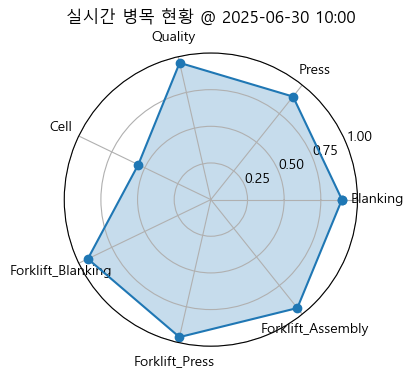

In [16]:
# # -*- coding: utf-8 -*-
# """
# 시간별 Queue CSV 기반 '보기 좋은' 대시보드
# - Paint/Cell=0 전체 제외, Warehouse 표기는 "Cell"
# - 라인업: 예측 밴드(EMA+감쇠) + 임계선 + 휴게/식사 음영 + 밴드 테두리
# - 예측 히트맵: quantile 정규화(옵션) + 핫스팟 라벨
# - 분포: 도넛 파이 + 가로 랭킹 바
# - 타임라인: 히트맵 or 소형 스파크라인 그리드 선택
# """

# import warnings
# warnings.filterwarnings("ignore")

# import numpy as np
# import pandas as pd
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# from matplotlib.font_manager import fontManager

# # =========================
# # 0) 설정
# # =========================
# CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

# TARGET_DATE = "2025-06-30"         # 하루 기준일
# TARGET_HOUR = "2025-06-30 10:00"   # 레이더/라인업 기준 시각

# ALERT_THRESHOLD = 0.8
# ALERT_MIN_SLOTS = 5

# # 예측 파라미터
# EMA_ALPHA = 0.4
# DECAY     = 0.92
# PAST_HOURS = 4
# FUT_LINEUP_SLOTS = 6     # 라인업 예측 길이
# FUT_HEAT_SLOTS   = 8     # 히트맵 예측 길이

# # 히트맵 스케일: "linear" or "quantile"
# HEATMAP_SCALE = "quantile"
# N_QUANT_BINS  = 10

# # 타임라인 표현: "heatmap" or "sparklines"
# TIMELINE_STYLE = "sparklines"

# # 스케줄 블록(휴게/식사 음영용)
# SCHEDULE_BLOCKS = [
#     ("07:50","09:50","주간"),
#     ("09:50","10:00","휴식"),
#     ("10:00","11:50","주간"),
#     ("11:50","12:40","중식"),
#     ("12:40","14:40","주간"),
#     ("14:40","14:50","휴식"),
#     ("14:50","16:40","주간"),
#     ("16:40","17:10","석식"),
#     ("17:10","20:10","잔업"),
#     ("20:10","20:40","휴식"),
#     ("20:40","00:00","야간"),
#     ("00:00","00:30","야식"),
#     ("00:30","04:00","야간"),
#     ("04:00","05:00","휴식"),
#     ("05:00","07:40","야간"),
# ]
# REST_LABELS = {"휴식","중식","석식","야식"}

# # =========================
# # 1) 폰트
# # =========================
# def set_korean_font():
#     mpl.rcParams["axes.unicode_minus"] = False
#     cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
#     avail = {f.name for f in fontManager.ttflist}
#     for n in cand:
#         if n in avail:
#             mpl.rcParams["font.family"] = n
#             return
# set_korean_font()

# # =========================
# # 2) 유틸
# # =========================
# def build_schedule_for_plot(day: pd.Timestamp) -> pd.DataFrame:
#     day = pd.Timestamp(day).floor("D")
#     anchor_start = pd.Timestamp(day.year,day.month,day.day,7,50)
#     anchor_end   = anchor_start + pd.Timedelta(hours=23, minutes=50)
#     rows=[]
#     for sstr, estr, label in SCHEDULE_BLOCKS:
#         sh,sm = map(int, sstr.split(":"))
#         eh,em = map(int, estr.split(":"))
#         s = pd.Timestamp(day.year,day.month,day.day,sh,sm)
#         e = pd.Timestamp(day.year,day.month,day.day,eh,em)
#         if (sh,sm) < (7,50): s += pd.Timedelta(days=1)
#         if (eh,em) < (7,50) or e <= s: e += pd.Timedelta(days=1)
#         s = max(s, anchor_start); e = min(e, anchor_end)
#         if e > s: rows.append({"start":s,"end":e,"label":label})
#     return pd.DataFrame(rows)

# def rest_intervals(day: pd.Timestamp):
#     sch = build_schedule_for_plot(day)
#     rest = sch[sch["label"].isin(REST_LABELS)][["start","end"]].sort_values("start")
#     merged=[]
#     if rest.empty: return merged
#     cur_s, cur_e = rest.iloc[0]["start"], rest.iloc[0]["end"]
#     for _, r in rest.iloc[1:].iterrows():
#         s, e = r["start"], r["end"]
#         if s <= cur_e: cur_e = max(cur_e, e)
#         else: merged.append((cur_s, cur_e)); cur_s, cur_e = s, e
#     merged.append((cur_s, cur_e))
#     return merged

# def shade_rest(ax, intervals, label="휴식/식사"):
#     if not intervals: return
#     for s,e in intervals:
#         ax.axvspan(s, e, color="grey", alpha=0.18, lw=0)
#     handles, labels = ax.get_legend_handles_labels()
#     if label not in labels:
#         handles.append(Patch(color="grey", alpha=0.18, label=label))
#         ax.legend(handles=handles, loc="best")

# def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
#     if len(series)==0: return [0.0]*steps
#     ema = series[0]
#     for v in series[1:]:
#         ema = alpha*v + (1-alpha)*ema
#     out=[]
#     for k in range(steps):
#         out.append(float(ema * (decay**k)))
#     return out

# # =========================
# # 3) 데이터 로드
# # =========================
# df = pd.read_csv(CSV_PATH, low_memory=False)
# df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
# df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
# df["_date"] = df["Time_Now"].dt.floor("D")
# df = df.sort_values("Time_Now").reset_index(drop=True)

# queue_cols = [c for c in df.columns if c.endswith("_Queue")]
# GROUP_MAP = {
#     "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking_") or c.lower()=="blanking_queue"],
#     "Press":      [c for c in queue_cols if c.lower().startswith("press")],
#     "Cell":       [c for c in queue_cols if c.lower().startswith("cell")],
#     "Paint":      [c for c in queue_cols if c.lower().startswith("paint")],
#     "Quality":    [c for c in queue_cols if c.lower().startswith("quality")],
#     "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
#     "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
#     "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
#     "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
# }
# GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

# valid_groups = {}
# for g, cols in GROUP_MAP.items():
#     df[f"{g}_Qsum"] = df[cols].sum(axis=1)
#     if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum() == 0: continue
#     if df[f"{g}_Qsum"].sum() == 0: continue
#     gmin, gmax = df[f"{g}_Qsum"].min(), df[f"{g}_Qsum"].max()
#     df[f"{g}_Qnorm"] = 0.0 if gmax==gmin else (df[f"{g}_Qsum"]-gmin)/(gmax-gmin)
#     valid_groups[g] = f"{g}_Qnorm"

# display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}
# DISPLAY_GROUPS = [display_name[g] for g in valid_groups]

# # =========================
# # 4) 경보
# # =========================
# TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
# THOUR = pd.Timestamp(TARGET_HOUR)
# day_df = df[df["_date"]==TDAY].copy()

# def detect_alert(day_df, col, thr=ALERT_THRESHOLD, min_run=ALERT_MIN_SLOTS):
#     x = (day_df[col] >= thr).astype(int).values
#     run=best=0
#     for v in x:
#         run = run+1 if v else 0
#         best = max(best, run)
#     return best>=min_run, best

# alerts=[]
# for g,col in valid_groups.items():
#     ok,streak = detect_alert(day_df, col)
#     if ok: alerts.append(f"{display_name[g]} {streak}슬롯 지속 ≥{ALERT_THRESHOLD}")
# print("알림 없음" if not alerts else "⚠️ " + " ; ".join(alerts))

# # =========================
# # 5) 레이더
# # =========================
# def nearest_slot(ts: pd.Timestamp, series: pd.Series) -> int:
#     return int(np.argmin(np.abs(series.values.astype("int64") - np.int64(ts.value))))

# live_ts = pd.Timestamp(TARGET_HOUR)
# if not day_df.empty:
#     idx = nearest_slot(live_ts, day_df["Time_Now"])
#     live_row = day_df.iloc[idx]
# else:
#     raise ValueError(f"{TARGET_DATE} 날짜 데이터가 비었습니다.")

# rad_vals = [float(live_row[valid_groups[g]]) for g in valid_groups.keys()]
# angles = np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False).tolist()
# rad_vals += rad_vals[:1]
# angles   += angles[:1]

# fig = plt.figure(figsize=(4.2, 4.2))
# ax = plt.subplot(111, polar=True)
# ax.plot(angles, rad_vals, marker="o")
# ax.fill(angles, rad_vals, alpha=0.25)
# ax.set_xticks(np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False))
# ax.set_xticklabels(DISPLAY_GROUPS)
# ax.set_yticks([0.25, 0.5, 0.75, 1.0])
# ax.set_title(f"실시간 병목 현황 @ {live_ts.strftime('%Y-%m-%d %H:%M')}")
# plt.tight_layout()
# plt.show()

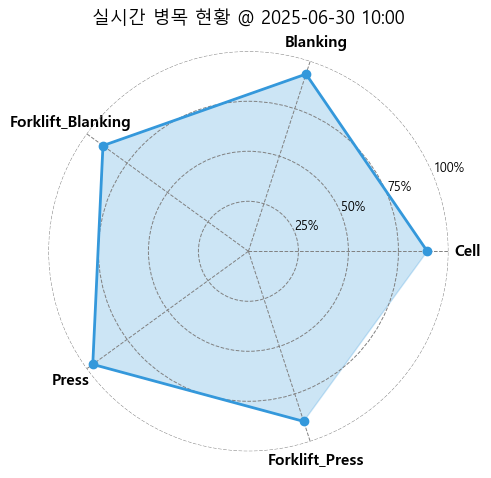

In [17]:
# # =========================
# # 레이더 차트 (개선 버전)
# # =========================
# groups_order = ["Cell", "Blanking", "Forklift_Blanking", "Press", "Forklift_Press"]
# rad_vals = [float(live_row[valid_groups[g]]) for g in groups_order if g in valid_groups]

# # 값 반복 (폐곡선)
# rad_vals += rad_vals[:1]
# angles = np.linspace(0, 2*np.pi, len(rad_vals), endpoint=False)

# fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(111, polar=True)

# # 라인 + 채우기
# ax.plot(angles, rad_vals, color="#3498db", linewidth=2, marker="o")
# ax.fill(angles, rad_vals, color="#3498db", alpha=0.25)

# # 축/라벨
# ax.set_xticks(np.linspace(0, 2*np.pi, len(groups_order), endpoint=False))
# ax.set_xticklabels(groups_order, fontsize=11, fontweight="bold")
# ax.set_yticks([0.25, 0.5, 0.75, 1.0])
# ax.set_yticklabels(["25%","50%","75%","100%"], fontsize=9)
# ax.set_ylim(0,1)

# # 스타일
# ax.spines["polar"].set_visible(False)
# ax.grid(color="grey", linestyle="--", linewidth=0.7)
# ax.set_title(f"실시간 병목 현황 @ {live_ts:%Y-%m-%d %H:%M}", fontsize=13, pad=20)

# plt.tight_layout()
# plt.show()

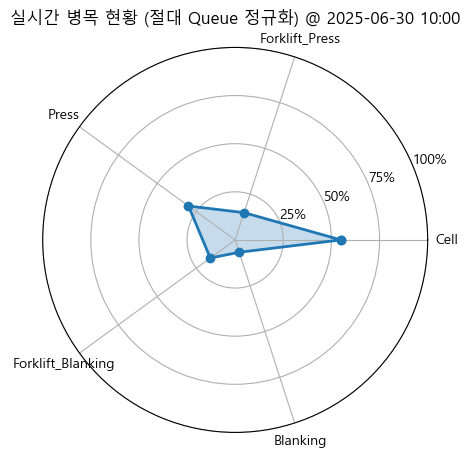

In [18]:
# # =========================
# # 레이더 차트 (절대 Queue + 전체 공정 공통 최대값 정규화)
# # =========================

# groups_order = ["Cell", "Forklift_Press", "Press", "Forklift_Blanking", "Blanking"]

# # 하루 데이터
# day_df = df[df["_date"]==TDAY].copy()
# if day_df.empty:
#     raise ValueError(f"{TDAY.date()} 데이터 없음")

# # 기준 시각
# live_ts = pd.Timestamp(TARGET_HOUR)
# idx = (day_df["Time_Now"]-live_ts).abs().idxmin()
# live_row = day_df.loc[idx]

# # 각 그룹의 절대 Queue 합계 컬럼 (_Qsum)
# sum_cols = {g: f"{g}_Qsum" for g in valid_groups if f"{g}_Qsum" in df.columns}

# # 전체 공정에서의 최대값
# global_max = max(df[c].max() for c in sum_cols.values())

# # 값 정규화 (절대값/공통최대)
# rad_vals = []
# for g in groups_order:
#     col = sum_cols.get(g.replace("Cell","Warehouse"), f"{g}_Qsum")  # warehouse→cell 매핑
#     if col in live_row:
#         rad_vals.append(live_row[col]/global_max)
#     else:
#         rad_vals.append(0.0)

# # 레이더 좌표 닫기
# angles = np.linspace(0, 2*np.pi, len(groups_order), endpoint=False).tolist()
# rad_vals += rad_vals[:1]
# angles   += angles[:1]

# # 그리기
# fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(111, polar=True)
# ax.plot(angles, rad_vals, marker="o", lw=2)
# ax.fill(angles, rad_vals, alpha=0.25)

# ax.set_xticks(np.linspace(0, 2*np.pi, len(groups_order), endpoint=False))
# ax.set_xticklabels(groups_order)
# ax.set_yticks([0.25,0.5,0.75,1.0])
# ax.set_yticklabels(["25%","50%","75%","100%"])
# ax.set_title(f"실시간 병목 현황 (절대 Queue 정규화) @ {live_ts.strftime('%Y-%m-%d %H:%M')}")
# plt.show()


[원본 Queue 값]
Cell                : 834.59
Forklift_Press      : 226.34
Press               : 455.32
Forklift_Blanking   : 242.78
Blanking            : 102.35
Global Max: 834.59


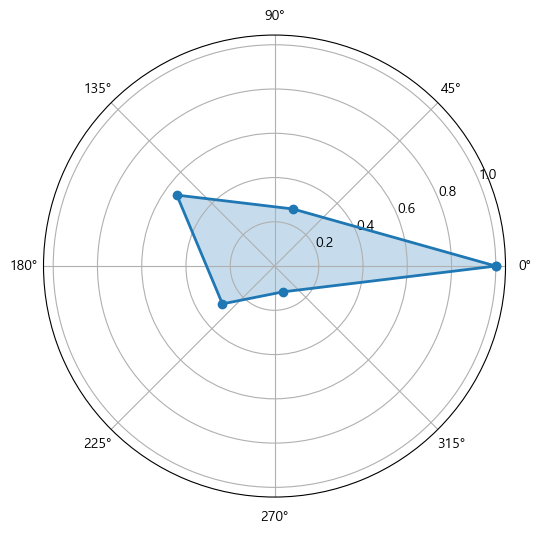

In [20]:
# # -*- coding: utf-8 -*-
# """
# 시간별 Queue 기반 실시간 병목 레이더 차트
# - Warehouse → Cell 매핑
# - 표시 그룹: Cell, Forklift_Press, Press, Forklift_Blanking, Blanking
# - 순서: Cell → Forklift_Press → Press → Forklift_Blanking → Blanking
# - 절대 Queue 값 기준 정규화 (global max)
# """

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from matplotlib.font_manager import fontManager

# # =========================
# # 0) 설정
# # =========================
# CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

# TARGET_DATE = "2025-06-30"
# TARGET_HOUR = "2025-06-30 10:00"

# # =========================
# # 1) 폰트 설정
# # =========================
# def set_korean_font():
#     mpl.rcParams["axes.unicode_minus"] = False
#     cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
#     avail = {f.name for f in fontManager.ttflist}
#     for n in cand:
#         if n in avail:
#             mpl.rcParams["font.family"] = n
#             return
# set_korean_font()

# # =========================
# # 2) 데이터 로드
# # =========================
# df = pd.read_csv(CSV_PATH, low_memory=False)
# df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
# df["_date"] = df["Time_Now"].dt.floor("D")

# queue_cols = [c for c in df.columns if c.endswith("_Queue")]

# # 그룹 매핑
# GROUP_MAP = {
#     "Blanking":   [c for c in queue_cols if "blanking" in c.lower() and "forklift" not in c.lower()],
#     "Press":      [c for c in queue_cols if c.lower().startswith("press")],
#     "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],   # → Cell
#     "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
#     "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
# }

# # 그룹 합계 생성
# valid_groups = {}
# for g, cols in GROUP_MAP.items():
#     if not cols: 
#         continue
#     df[f"{g}_Qsum"] = df[cols].sum(axis=1)
#     if df[f"{g}_Qsum"].sum() == 0:
#         continue
#     valid_groups[g] = f"{g}_Qsum"

# # 표시 그룹 (순서 지정)
# DISPLAY_ORDER = ["Cell", "Forklift_Press", "Press", "Forklift_Blanking", "Blanking"]
# display_name = {g: ("Cell" if g == "Warehouse" else g) for g in valid_groups}
# DISPLAY_GROUPS = [g for g in DISPLAY_ORDER if g in display_name.values()]

# # =========================
# # 3) 대상 시점 선택
# # =========================
# TDAY = pd.Timestamp(TARGET_DATE).floor("D")
# THOUR = pd.Timestamp(TARGET_HOUR)

# day_df = df[df["_date"] == TDAY].copy()
# if day_df.empty:
#     raise ValueError(f"{TDAY.date()} 날짜 데이터 없음")

# # 가장 가까운 슬롯 선택
# idx = np.argmin(np.abs(day_df["Time_Now"].values.astype("int64") - np.int64(THOUR.value)))
# live_row = day_df.iloc[idx]

# # =========================
# # 4) 값 정규화 (절대 Queue 기준)
# # =========================
# raw_vals = []
# for g in DISPLAY_ORDER:
#     for k,v in display_name.items():
#         if v == g:
#             raw_vals.append(float(live_row[valid_groups[k]]))
#             break

# raw_vals = np.array(raw_vals)
# global_max = raw_vals.max() if raw_vals.max() > 0 else 1
# norm_vals = raw_vals / global_max

# # =========================
# # 5) 레이더 차트
# # =========================
# angles = np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False).tolist()
# angles += angles[:1]   # 첫 점을 다시 붙임

# vals = norm_vals.tolist()
# vals += vals[:1]       # 첫 값 다시 붙임

# fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
# ax.plot(angles, vals, marker="o", linewidth=2, color="tab:blue")
# ax.fill(angles, vals, alpha=0.25, color="tab:blue")


# # =========================
# # 6) 원본 값 출력 (진짜 수치 확인용)
# # =========================
# print("\n[원본 Queue 값]")
# for g,v in zip(DISPLAY_GROUPS, raw_vals):
#     print(f"{g:20s}: {v:,.2f}")
# print(f"Global Max: {global_max:,.2f}")

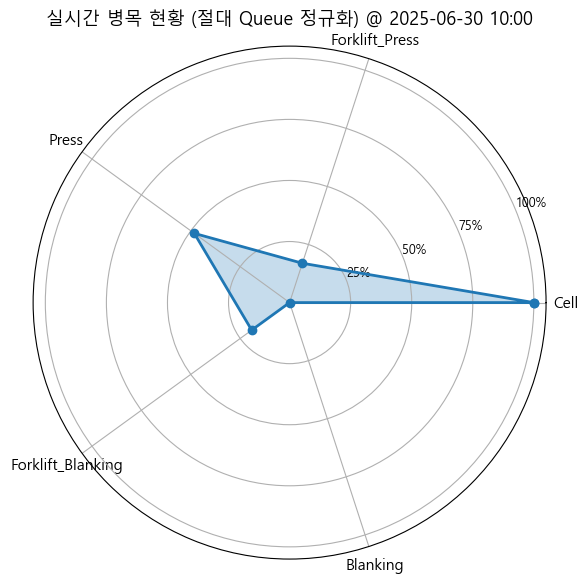

In [21]:
# # -*- coding: utf-8 -*-
# """
# 시간별 Queue CSV 기반 레이더 차트 (Blanking, Forklift_Blanking, Press, Forklift_Press, Cell)
# - Warehouse를 Cell로 매핑
# - 절대 Queue 값 정규화해서 표시
# - 레이더 차트에 축 라벨(공정명)과 반지름 라벨(%) 추가
# """

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.font_manager import fontManager
# import matplotlib as mpl

# # =========================
# # 0) 설정
# # =========================
# CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

# TARGET_DATE = "2025-06-30"
# TARGET_HOUR = "2025-06-30 10:00"

# # =========================
# # 1) 한글 폰트 설정
# # =========================
# def set_korean_font():
#     mpl.rcParams["axes.unicode_minus"] = False
#     cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
#     avail = {f.name for f in fontManager.ttflist}
#     for n in cand:
#         if n in avail:
#             mpl.rcParams["font.family"] = n
#             return
# set_korean_font()

# # =========================
# # 2) 데이터 로드
# # =========================
# df = pd.read_csv(CSV_PATH, low_memory=False)
# df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
# df["_date"] = df["Time_Now"].dt.floor("D")
# df = df.sort_values("Time_Now").reset_index(drop=True)

# queue_cols = [c for c in df.columns if c.endswith("_Queue")]

# # 그룹 매핑 (Warehouse → Cell)
# GROUP_MAP = {
#     "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking")],
#     "Press":      [c for c in queue_cols if c.lower().startswith("press")],
#     "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
#     "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
#     "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
# }
# GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

# valid_groups = {}
# for g, cols in GROUP_MAP.items():
#     df[f"{g}_Qsum"] = df[cols].sum(axis=1)
#     if df[f"{g}_Qsum"].sum() == 0:
#         continue
#     valid_groups[g] = f"{g}_Qsum"

# # Warehouse는 Cell로 표기
# display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# # 표시 순서 (위에서 아래: Cell, Forklift_Press, Press, Forklift_Blanking, Blanking)
# DISPLAY_ORDER = ["Cell","Forklift_Press","Press","Forklift_Blanking","Blanking"]

# # =========================
# # 3) 레이더 차트 데이터
# # =========================
# TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
# THOUR = pd.Timestamp(TARGET_HOUR)

# day_df = df[df["_date"]==TDAY].copy()
# if day_df.empty:
#     raise ValueError(f"{TDAY.date()} 날짜 데이터가 없습니다.")

# # 대상 시간 슬롯 찾기
# idx = np.argmin(np.abs(day_df["Time_Now"].values.astype("int64") - np.int64(THOUR.value)))
# live_row = day_df.iloc[idx]

# # 선택 그룹 값 추출
# vals = []
# for g in DISPLAY_ORDER:
#     # Cell은 Warehouse 값 사용
#     src = "Warehouse" if g=="Cell" else g
#     col = valid_groups[src]
#     vals.append(float(live_row[col]))

# # 정규화 (0~1)
# vmin, vmax = min(vals), max(vals)
# norm_vals = [(v - vmin)/(vmax - vmin) if vmax>vmin else 0 for v in vals]

# # =========================
# # 4) 레이더 차트 그리기
# # =========================
# angles = np.linspace(0, 2*np.pi, len(DISPLAY_ORDER), endpoint=False).tolist()
# angles += angles[:1]   # 첫 점 반복
# vals = norm_vals + norm_vals[:1]

# fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
# ax.plot(angles, vals, marker="o", linewidth=2, color="tab:blue")
# ax.fill(angles, vals, alpha=0.25, color="tab:blue")

# # 축 라벨 (공정명)
# ax.set_xticks(np.linspace(0, 2*np.pi, len(DISPLAY_ORDER), endpoint=False))
# ax.set_xticklabels(DISPLAY_ORDER, fontsize=11)

# # 반지름 라벨 (퍼센트)
# ax.set_yticks([0.25, 0.5, 0.75, 1.0])
# ax.set_yticklabels(["25%","50%","75%","100%"], fontsize=9)

# ax.set_title(f"실시간 병목 현황 (절대 Queue 정규화) @ {THOUR:%Y-%m-%d %H:%M}", fontsize=13)
# plt.tight_layout()
# plt.show()

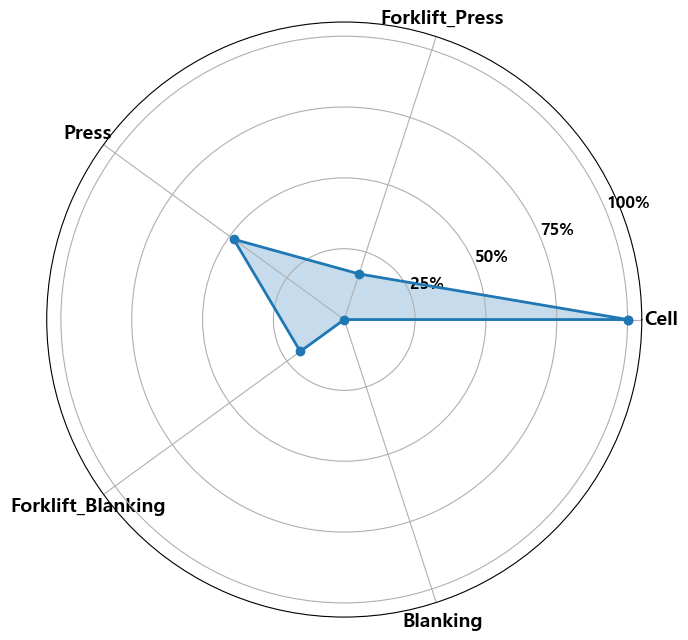

In [23]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 레이더 차트 (글자 크게 보기 좋게)
- 표시 그룹: Cell(Warehouse), Forklift_Press, Press, Forklift_Blanking, Blanking
- 절대 Queue 값 정규화 (0~1)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import matplotlib as mpl

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-06-30"
TARGET_HOUR = "2025-06-30 10:00"

# =========================
# 1) 한글 폰트
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]

# 그룹 매핑
GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking")],
    "Press":      [c for c in queue_cols if c.lower().startswith("press")],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    if df[f"{g}_Qsum"].sum() == 0:
        continue
    valid_groups[g] = f"{g}_Qsum"

display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# 표시 순서 (위에서 아래: Cell → Forklift_Press → Press → Forklift_Blanking → Blanking)
DISPLAY_ORDER = ["Cell","Forklift_Press","Press","Forklift_Blanking","Blanking"]

# =========================
# 3) 데이터 준비
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)

day_df = df[df["_date"]==TDAY].copy()
if day_df.empty:
    raise ValueError(f"{TDAY.date()} 날짜 데이터가 없습니다.")

# 대상 시간 슬롯
idx = np.argmin(np.abs(day_df["Time_Now"].values.astype("int64") - np.int64(THOUR.value)))
live_row = day_df.iloc[idx]

# 값 추출
vals = []
for g in DISPLAY_ORDER:
    src = "Warehouse" if g=="Cell" else g
    col = valid_groups[src]
    vals.append(float(live_row[col]))

# 정규화
vmin, vmax = min(vals), max(vals)
norm_vals = [(v - vmin)/(vmax - vmin) if vmax>vmin else 0 for v in vals]

# =========================
# 4) 레이더 차트
# =========================
angles = np.linspace(0, 2*np.pi, len(DISPLAY_ORDER), endpoint=False).tolist()
angles += angles[:1]
vals = norm_vals + norm_vals[:1]

fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))  # ← 그림 더 크게
ax.plot(angles, vals, marker="o", linewidth=2, color="tab:blue")
ax.fill(angles, vals, alpha=0.25, color="tab:blue")

# 축 라벨 (공정명 크게, 굵게)
ax.set_xticks(np.linspace(0, 2*np.pi, len(DISPLAY_ORDER), endpoint=False))
ax.set_xticklabels(DISPLAY_ORDER, fontsize=14, fontweight="bold")

# 반지름 라벨 크게
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["25%","50%","75%","100%"], fontsize=12, fontweight="bold")

# 제목 크게
# ax.set_title(f"실시간 병목 현황 (절대 Queue 정규화) @ {THOUR:%Y-%m-%d %H:%M}", fontsize=15, fontweight="bold", pad=20)

plt.tight_layout()
plt.show()

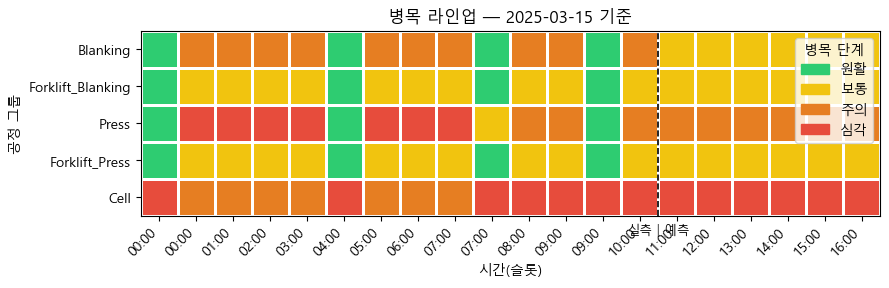

In [7]:
# -*- coding: utf-8 -*-
"""
병목 라인업(타일) 시각화
- 표시 순서: Cell(=Warehouse) → Forklift_Press → Press → Forklift_Blanking → Blanking
- 제외: Forklift_Assembly, Quality, Paint
- '심각'은 각 시간대에서 큐가 가장 큰 1개만 빨강으로 표시
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"
TARGET_HOUR = "2025-03-15 10:00"

# 예측 파라미터
EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 12
FUT_LINEUP_SLOTS = 6

# 단계 구간 (절대 Queue 기준)
STAGE_BINS   = [0, 100, 300, 600, np.inf]
STAGE_LABELS = ["원활", "보통", "주의", "심각"]
STAGE_COLORS = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]

# =========================
# 한글 폰트
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# EMA 유틸
# =========================
def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    return [float(ema * (decay**k)) for k in range(steps)]

# =========================
# 데이터 로드 & 그룹
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if "blanking" in c.lower()],
    "Press":      [c for c in queue_cols if "press" in c.lower()],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)

# =========================
# 표시 순서 (위→아래: Cell → Forklift_Press → Press → Forklift_Blanking → Blanking)
# =========================
DISPLAY_ORDER = [
    ("Warehouse",         "Cell"),
    ("Forklift_Press",    "Forklift_Press"),
    ("Press",             "Press"),
    ("Forklift_Blanking", "Forklift_Blanking"),
    ("Blanking",          "Blanking"),
]

valid_map = {}
for src_name, show_name in DISPLAY_ORDER:
    colname = f"{src_name}_Qsum"
    if colname not in df.columns:
        df[colname] = 0.0
    valid_map[show_name] = colname

PLOT_GROUPS = [show_name for _, show_name in DISPLAY_ORDER]

# =========================
# 타임라인 데이터
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)

day_df = df[df["_date"]==TDAY].copy()
board = day_df.copy(); board["t"] = board["Time_Now"]

slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0]

past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=PAST_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

start_pred = (past["t"].iloc[-1] if len(past)>0 else THOUR) + slot_delta
pred_times = [start_pred + k*slot_delta for k in range(FUT_LINEUP_SLOTS)]
pred = pd.DataFrame({"t": pred_times})

hist = board[board["t"] <= THOUR].tail(8)
for show_name, colname in valid_map.items():
    series = hist[colname].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[show_name] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

timeline_times = list(past["t"].values) + pred["t"].tolist()
M, N = len(PLOT_GROUPS), len(timeline_times)

mat = np.zeros((M, N))
for i, show_name in enumerate(PLOT_GROUPS):
    col = valid_map[show_name]
    if len(past)>0:
        mat[i, :len(past)] = past[col].astype(float).fillna(0.0).values
    mat[i, len(past):] = np.asarray(pred[show_name], float)

# 단계 배정
mat_stage = np.zeros_like(mat, dtype=int)
for k in range(len(STAGE_BINS)-1):
    mask = (mat >= STAGE_BINS[k]) & (mat < STAGE_BINS[k+1])
    mat_stage[mask] = k

# 시간별 심각(최댓값 1개)
SEV = len(STAGE_LABELS)-1
for j in range(N):
    mat_stage[:, j] = np.where(mat_stage[:, j]==SEV, SEV-1, mat_stage[:, j])
    i_max = int(np.nanargmax(mat[:, j]))
    mat_stage[i_max, j] = SEV

# =========================
# 시각화
# =========================
fig, ax = plt.subplots(figsize=(max(9, 0.45*N), max(3.2, 0.7*M)))

cmap  = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = np.arange(len(STAGE_LABELS)+1) - 0.5
norm  = mpl.colors.BoundaryNorm(bounds, cmap.N)

x_edges = np.arange(N+1); y_edges = np.arange(M+1)
quad = ax.pcolormesh(x_edges, y_edges, mat_stage, cmap=cmap, norm=norm,
                     edgecolors="white", linewidth=0.9, shading="flat")
ax.set_aspect("equal")

# 라벨
ax.set_yticks(np.arange(M)+0.5)
ax.set_yticklabels(PLOT_GROUPS)
step = max(1, N//12)
ax.set_xticks(np.arange(N)[::step]+0.5)
ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
                   rotation=45, ha="right")

# 실측/예측 경계
if len(past)>0 and len(pred)>0:
    ax.axvline(len(past), color="black", lw=1.2, ls="--")
    ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

# 범례
legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
ax.legend(handles=legend_handles, loc="upper right", title="병목 단계")

ax.set_title(f"병목 라인업 — {TARGET_DATE} 기준")
ax.set_xlabel("시간(슬롯)")
ax.set_ylabel("공정 그룹")

plt.tight_layout()
plt.show()